In [2]:
import gym
import random
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

class DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.997
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        # create replay memory using deque
        self.memory = deque(maxlen=5000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()

        if self.load_model:
            self.model.load_weights("./save_model/cartpole_dqn.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(128, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(128, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            action_idx = random.randrange(self.action_size)
            return action_idx, np.eye(self.action_size)[action_idx]
        else:
            q_value = self.model.predict(state)
            action_idx = np.argmax(q_value[0])
            return action_idx, np.eye(self.action_size)[action_idx]

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        # and do the model fit!
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)

C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\tensorf

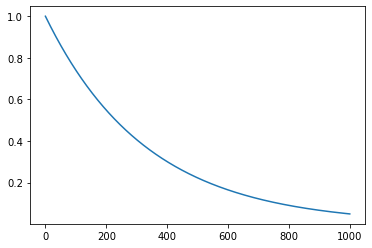

In [19]:
import matplotlib.pyplot as plt

eps = 1000
decay = 0.997
plt.plot([decay**i for i in range(eps)]);

# Single-Agent

In [20]:
import gym
import slimevolleygym

env = gym.make("SlimeVolley-v0")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)
# agent.render = True
scores, episodes = [], []

EPISODES = 1000

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               1664      
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 387       
Total params: 35,075
Trainable params: 35,075
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               1664      
____________________________

In [25]:
from tqdm.notebook import tqdm

for e in tqdm(range(EPISODES)):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    
    t = 0
    while not done:
        if agent.render:
            env.render()

        # get action for the current state and go one step in environment
        action_idx, action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        
        # if an action make the episode end, then gives penalty of -100
#         reward = reward if not done or score == 499 else -100

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action_idx, reward, next_state, done)
        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
#             score = score if score == 500 else score + 100
            scores.append(score)
            episodes.append(e)
            print(f"episode: {e} t: {t} score:{score} memory length: {len(agent.memory)} epsilon: {agent.epsilon}")

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                sys.exit()
        t += 1
    agent.decay_epsilon()

episode: 0 t: 569 score:-5 memory length: 5000 epsilon: 0.9704017769489168
episode: 1 t: 410 score:-5 memory length: 5000 epsilon: 0.9674905716180701
episode: 2 t: 488 score:-5 memory length: 5000 epsilon: 0.9645880999032158
episode: 3 t: 577 score:-5 memory length: 5000 epsilon: 0.9616943356035061
episode: 4 t: 603 score:-4 memory length: 5000 epsilon: 0.9588092525966956
episode: 5 t: 642 score:-4 memory length: 5000 epsilon: 0.9559328248389055
episode: 6 t: 448 score:-5 memory length: 5000 epsilon: 0.9530650263643888
episode: 7 t: 407 score:-5 memory length: 5000 epsilon: 0.9502058312852957
episode: 8 t: 475 score:-5 memory length: 5000 epsilon: 0.9473552137914398
episode: 9 t: 409 score:-5 memory length: 5000 epsilon: 0.9445131481500655
episode: 10 t: 670 score:-4 memory length: 5000 epsilon: 0.9416796087056153
episode: 11 t: 401 score:-5 memory length: 5000 epsilon: 0.9388545698794984
episode: 12 t: 666 score:-4 memory length: 5000 epsilon: 0.93603800616986
episode: 13 t: 745 score

episode: 109 t: 563 score:-5 memory length: 5000 epsilon: 0.6993971191334902
episode: 110 t: 665 score:-5 memory length: 5000 epsilon: 0.6972989277760897
episode: 111 t: 540 score:-5 memory length: 5000 epsilon: 0.6952070309927615
episode: 112 t: 606 score:-5 memory length: 5000 epsilon: 0.6931214098997832
episode: 113 t: 801 score:-3 memory length: 5000 epsilon: 0.6910420456700839
episode: 114 t: 538 score:-5 memory length: 5000 epsilon: 0.6889689195330736
episode: 115 t: 439 score:-5 memory length: 5000 epsilon: 0.6869020127744744
episode: 116 t: 594 score:-5 memory length: 5000 epsilon: 0.684841306736151
episode: 117 t: 788 score:-5 memory length: 5000 epsilon: 0.6827867828159425
episode: 118 t: 438 score:-5 memory length: 5000 epsilon: 0.6807384224674947
episode: 119 t: 462 score:-5 memory length: 5000 epsilon: 0.6786962072000923
episode: 120 t: 585 score:-5 memory length: 5000 epsilon: 0.676660118578492
episode: 121 t: 646 score:-5 memory length: 5000 epsilon: 0.6746301382227565
e

episode: 216 t: 726 score:-5 memory length: 5000 epsilon: 0.5071142079207761
episode: 217 t: 546 score:-5 memory length: 5000 epsilon: 0.5055928652970137
episode: 218 t: 413 score:-5 memory length: 5000 epsilon: 0.5040760867011227
episode: 219 t: 498 score:-5 memory length: 5000 epsilon: 0.5025638584410194
episode: 220 t: 589 score:-5 memory length: 5000 epsilon: 0.5010561668656963
episode: 221 t: 599 score:-5 memory length: 5000 epsilon: 0.49955299836509925
episode: 222 t: 539 score:-5 memory length: 5000 epsilon: 0.49805433937000393
episode: 223 t: 491 score:-5 memory length: 5000 epsilon: 0.4965601763518939
episode: 224 t: 497 score:-5 memory length: 5000 epsilon: 0.49507049582283824
episode: 225 t: 480 score:-5 memory length: 5000 epsilon: 0.49358528433536975
episode: 226 t: 533 score:-5 memory length: 5000 epsilon: 0.49210452848236363
episode: 227 t: 642 score:-5 memory length: 5000 epsilon: 0.49062821489691655
episode: 228 t: 693 score:-4 memory length: 5000 epsilon: 0.4891563302

episode: 322 t: 593 score:-5 memory length: 5000 epsilon: 0.36880139869897294
episode: 323 t: 623 score:-5 memory length: 5000 epsilon: 0.367694994502876
episode: 324 t: 607 score:-5 memory length: 5000 epsilon: 0.3665919095193674
episode: 325 t: 356 score:-5 memory length: 5000 epsilon: 0.36549213379080925
episode: 326 t: 742 score:-5 memory length: 5000 epsilon: 0.3643956573894368
episode: 327 t: 730 score:-5 memory length: 5000 epsilon: 0.3633024704172685
episode: 328 t: 495 score:-5 memory length: 5000 epsilon: 0.3622125630060167
episode: 329 t: 592 score:-5 memory length: 5000 epsilon: 0.3611259253169986
episode: 330 t: 486 score:-5 memory length: 5000 epsilon: 0.3600425475410476
episode: 331 t: 631 score:-5 memory length: 5000 epsilon: 0.3589624198984244
episode: 332 t: 459 score:-5 memory length: 5000 epsilon: 0.35788553263872913
episode: 333 t: 476 score:-5 memory length: 5000 epsilon: 0.35681187604081294
episode: 334 t: 540 score:-5 memory length: 5000 epsilon: 0.3557414404126

episode: 428 t: 497 score:-5 memory length: 5000 epsilon: 0.26821270151351667
episode: 429 t: 685 score:-5 memory length: 5000 epsilon: 0.2674080634089761
episode: 430 t: 425 score:-5 memory length: 5000 epsilon: 0.2666058392187492
episode: 431 t: 642 score:-5 memory length: 5000 epsilon: 0.26580602170109296
episode: 432 t: 533 score:-5 memory length: 5000 epsilon: 0.26500860363598966
episode: 433 t: 462 score:-5 memory length: 5000 epsilon: 0.2642135778250817
episode: 434 t: 557 score:-5 memory length: 5000 epsilon: 0.26342093709160647
episode: 435 t: 782 score:-5 memory length: 5000 epsilon: 0.26263067428033166
episode: 436 t: 600 score:-5 memory length: 5000 epsilon: 0.26184278225749064
episode: 437 t: 980 score:-5 memory length: 5000 epsilon: 0.26105725391071816
episode: 438 t: 740 score:-5 memory length: 5000 epsilon: 0.260274082148986
episode: 439 t: 515 score:-5 memory length: 5000 epsilon: 0.2594932599025391
episode: 440 t: 539 score:-5 memory length: 5000 epsilon: 0.2587147801

episode: 534 t: 572 score:-5 memory length: 5000 epsilon: 0.1950590575495539
episode: 535 t: 658 score:-5 memory length: 5000 epsilon: 0.19447388037690524
episode: 536 t: 515 score:-5 memory length: 5000 epsilon: 0.19389045873577454
episode: 537 t: 422 score:-5 memory length: 5000 epsilon: 0.19330878735956722
episode: 538 t: 465 score:-5 memory length: 5000 epsilon: 0.1927288609974885
episode: 539 t: 540 score:-5 memory length: 5000 epsilon: 0.19215067441449604
episode: 540 t: 571 score:-5 memory length: 5000 epsilon: 0.19157422239125255
episode: 541 t: 483 score:-5 memory length: 5000 epsilon: 0.1909994997240788
episode: 542 t: 508 score:-5 memory length: 5000 epsilon: 0.19042650122490654
episode: 543 t: 497 score:-5 memory length: 5000 epsilon: 0.18985522172123181
episode: 544 t: 373 score:-5 memory length: 5000 epsilon: 0.18928565605606812
episode: 545 t: 655 score:-5 memory length: 5000 epsilon: 0.1887177990878999
episode: 546 t: 560 score:-4 memory length: 5000 epsilon: 0.18815164

episode: 640 t: 552 score:-5 memory length: 5000 epsilon: 0.14185769621429614
episode: 641 t: 718 score:-5 memory length: 5000 epsilon: 0.14143212312565326
episode: 642 t: 655 score:-5 memory length: 5000 epsilon: 0.1410078267562763
episode: 643 t: 562 score:-5 memory length: 5000 epsilon: 0.14058480327600748
episode: 644 t: 436 score:-5 memory length: 5000 epsilon: 0.14016304886617945
episode: 645 t: 604 score:-4 memory length: 5000 epsilon: 0.1397425597195809
episode: 646 t: 524 score:-5 memory length: 5000 epsilon: 0.13932333204042216
episode: 647 t: 572 score:-5 memory length: 5000 epsilon: 0.1389053620443009
episode: 648 t: 513 score:-5 memory length: 5000 epsilon: 0.138488645958168
episode: 649 t: 473 score:-5 memory length: 5000 epsilon: 0.1380731800202935
episode: 650 t: 835 score:-4 memory length: 5000 epsilon: 0.13765896048023263
episode: 651 t: 777 score:-5 memory length: 5000 epsilon: 0.13724598359879192
episode: 652 t: 901 score:-5 memory length: 5000 epsilon: 0.1368342456

episode: 746 t: 812 score:-5 memory length: 5000 epsilon: 0.10316673436256728
episode: 747 t: 468 score:-5 memory length: 5000 epsilon: 0.10285723415947957
episode: 748 t: 843 score:-5 memory length: 5000 epsilon: 0.10254866245700113
episode: 749 t: 482 score:-5 memory length: 5000 epsilon: 0.10224101646963013
episode: 750 t: 600 score:-5 memory length: 5000 epsilon: 0.10193429342022124
episode: 751 t: 606 score:-5 memory length: 5000 epsilon: 0.10162849053996058
episode: 752 t: 612 score:-5 memory length: 5000 epsilon: 0.10132360506834069
episode: 753 t: 519 score:-5 memory length: 5000 epsilon: 0.10101963425313566
episode: 754 t: 661 score:-5 memory length: 5000 epsilon: 0.10071657535037626
episode: 755 t: 478 score:-5 memory length: 5000 epsilon: 0.10041442562432513
episode: 756 t: 643 score:-5 memory length: 5000 epsilon: 0.10011318234745216
episode: 757 t: 446 score:-5 memory length: 5000 epsilon: 0.0998128428004098
episode: 758 t: 657 score:-5 memory length: 5000 epsilon: 0.09951

episode: 852 t: 552 score:-4 memory length: 5000 epsilon: 0.07502853467293165
episode: 853 t: 519 score:-5 memory length: 5000 epsilon: 0.07480344906891286
episode: 854 t: 480 score:-5 memory length: 5000 epsilon: 0.07457903872170611
episode: 855 t: 609 score:-5 memory length: 5000 epsilon: 0.07435530160554099
episode: 856 t: 613 score:-4 memory length: 5000 epsilon: 0.07413223570072437
episode: 857 t: 691 score:-5 memory length: 5000 epsilon: 0.0739098389936222
episode: 858 t: 556 score:-5 memory length: 5000 epsilon: 0.07368810947664134
episode: 859 t: 630 score:-5 memory length: 5000 epsilon: 0.07346704514821141
episode: 860 t: 456 score:-5 memory length: 5000 epsilon: 0.07324664401276677
episode: 861 t: 619 score:-5 memory length: 5000 epsilon: 0.07302690408072847
episode: 862 t: 574 score:-5 memory length: 5000 epsilon: 0.07280782336848628
episode: 863 t: 595 score:-5 memory length: 5000 epsilon: 0.07258939989838081
episode: 864 t: 690 score:-5 memory length: 5000 epsilon: 0.07237

episode: 958 t: 638 score:-5 memory length: 5000 epsilon: 0.054564885182697184
episode: 959 t: 427 score:-5 memory length: 5000 epsilon: 0.05440119052714909
episode: 960 t: 751 score:-4 memory length: 5000 epsilon: 0.05423798695556764
episode: 961 t: 579 score:-5 memory length: 5000 epsilon: 0.05407527299470094
episode: 962 t: 611 score:-5 memory length: 5000 epsilon: 0.053913047175716836
episode: 963 t: 523 score:-5 memory length: 5000 epsilon: 0.05375130803418968
episode: 964 t: 621 score:-5 memory length: 5000 epsilon: 0.05359005411008711
episode: 965 t: 895 score:-5 memory length: 5000 epsilon: 0.053429283947756846
episode: 966 t: 543 score:-5 memory length: 5000 epsilon: 0.053268996095913575
episode: 967 t: 720 score:-4 memory length: 5000 epsilon: 0.05310918910762583
episode: 968 t: 531 score:-5 memory length: 5000 epsilon: 0.052949861540302956
episode: 969 t: 525 score:-5 memory length: 5000 epsilon: 0.052791011955682046
episode: 970 t: 585 score:-5 memory length: 5000 epsilon: 

In [54]:
# Test run
state = env.reset()
state = np.reshape(state, [1, state_size])

total_reward = 0
done = False

while not done:
    action_idx, action = agent.get_action(state)
    state, reward, done, info = env.step(action)
    state = np.reshape(state, [1, state_size])
    total_reward += reward
    env.render()
print(f"Reward: {total_reward}")

Reward: -5


# Multi-agent

In [7]:
import gym
import slimevolleygym

env = gym.make("SlimeVolley-v0")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent1 = DQNAgent(state_size, action_size)
agent2 = DQNAgent(state_size, action_size)
# agent.render = True
scores1, episodes1 = [], []
scores2, episodes2 = [], []

EPISODES = 1000

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               1664      
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 387       
Total params: 35,075
Trainable params: 35,075
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               1664      
____________________________

In [9]:
from tqdm.notebook import tqdm
t = 0
for e in tqdm(range(EPISODES)):
    done = False
    score1 = 0
    score2 = 0
    
    state1 = env.reset()
    state1 = np.reshape(state1, [1, state_size])
    state2 = state1
    
    while not done:
        if agent1.render:
            env.render()

        # get action for the current state and go one step in environment
        action_idx1, action1 = agent1.get_action(state1)
        action_idx2, action2 = agent2.get_action(state2)
        
        next_state1, reward, done, info = env.step(action1, action2)
        next_state2 = info['otherObs']
        next_state1 = np.reshape(next_state1, [1, state_size])
        next_state2 = np.reshape(next_state2, [1, state_size])
        
        # if an action make the episode end, then gives penalty of -100
#         reward = reward if not done or score == 499 else -100

        # save the sample <s, a, r, s'> to the replay memory
        agent1.append_sample(state1, action_idx1, reward, next_state1, done)
        agent2.append_sample(state2, action_idx2, -reward, next_state2, done)
        
        # every time step do the training
        agent1.train_model()
        agent2.train_model()
        score1 += reward
        score2 += -reward
        state1 = next_state1
        state2 = next_state2

        if done:
            # every episode update the target model to be same with model
            agent1.update_target_model()
            agent2.update_target_model()

            # every episode, plot the play time
#             score = score if score == 500 else score + 100
            scores1.append(score1)
            scores2.append(score2)
            episodes1.append(e)
            episodes2.append(e)
            print(f"t: {t} episode: {e} score1: {score1} memory length: {len(agent1.memory)} epsilon: {agent1.epsilon}")
            print(f"t: {t} episode: {e} score2: {score2} memory length: {len(agent2.memory)} epsilon: {agent2.epsilon}")

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training
            if np.mean(scores1[-min(10, len(scores1)):]) > 490 or np.mean(scores2[-min(10, len(scores2)):]) > 490:
                sys.exit()
        t += 1
    agent1.decay_epsilon()
    agent2.decay_epsilon()

episode: 0 t: 481 score1: 4 memory length: 1159 epsilon: 1.0
episode: 0 t: 481 score2: -4 memory length: 1159 epsilon: 1.0
episode: 1 t: 767 score1: -1 memory length: 1927 epsilon: 0.997
episode: 1 t: 767 score2: 1 memory length: 1927 epsilon: 0.997
episode: 2 t: 626 score1: -2 memory length: 2554 epsilon: 0.994009
episode: 2 t: 626 score2: 2 memory length: 2554 epsilon: 0.994009
episode: 3 t: 685 score1: -2 memory length: 3240 epsilon: 0.991026973
episode: 3 t: 685 score2: 2 memory length: 3240 epsilon: 0.991026973
episode: 4 t: 687 score1: 2 memory length: 3928 epsilon: 0.988053892081
episode: 4 t: 687 score2: -2 memory length: 3928 epsilon: 0.988053892081
episode: 5 t: 643 score1: 2 memory length: 4572 epsilon: 0.985089730404757
episode: 5 t: 643 score2: -2 memory length: 4572 epsilon: 0.985089730404757
episode: 6 t: 706 score1: 2 memory length: 5000 epsilon: 0.9821344612135428
episode: 6 t: 706 score2: -2 memory length: 5000 epsilon: 0.9821344612135428
episode: 7 t: 507 score1: 4 m

episode: 54 t: 733 score1: -1 memory length: 5000 epsilon: 0.8502341582884777
episode: 54 t: 733 score2: 1 memory length: 5000 epsilon: 0.8502341582884777
episode: 55 t: 604 score1: 3 memory length: 5000 epsilon: 0.8476834558136123
episode: 55 t: 604 score2: -3 memory length: 5000 epsilon: 0.8476834558136123
episode: 56 t: 472 score1: -4 memory length: 5000 epsilon: 0.8451404054461714
episode: 56 t: 472 score2: 4 memory length: 5000 epsilon: 0.8451404054461714
episode: 57 t: 675 score1: -2 memory length: 5000 epsilon: 0.8426049842298329
episode: 57 t: 675 score2: 2 memory length: 5000 epsilon: 0.8426049842298329
episode: 58 t: 697 score1: 2 memory length: 5000 epsilon: 0.8400771692771434
episode: 58 t: 697 score2: -2 memory length: 5000 epsilon: 0.8400771692771434
episode: 59 t: 877 score1: -1 memory length: 5000 epsilon: 0.837556937769312
episode: 59 t: 877 score2: 1 memory length: 5000 epsilon: 0.837556937769312
episode: 60 t: 633 score1: -2 memory length: 5000 epsilon: 0.83504426695

episode: 107 t: 660 score1: 2 memory length: 5000 epsilon: 0.7250733439523728
episode: 107 t: 660 score2: -2 memory length: 5000 epsilon: 0.7250733439523728
episode: 108 t: 825 score1: 1 memory length: 5000 epsilon: 0.7228981239205157
episode: 108 t: 825 score2: -1 memory length: 5000 epsilon: 0.7228981239205157
episode: 109 t: 501 score1: -4 memory length: 5000 epsilon: 0.7207294295487541
episode: 109 t: 501 score2: 4 memory length: 5000 epsilon: 0.7207294295487541
episode: 110 t: 547 score1: -3 memory length: 5000 epsilon: 0.7185672412601078
episode: 110 t: 547 score2: 3 memory length: 5000 epsilon: 0.7185672412601078
episode: 111 t: 706 score1: -2 memory length: 5000 epsilon: 0.7164115395363275
episode: 111 t: 706 score2: 2 memory length: 5000 epsilon: 0.7164115395363275
episode: 112 t: 728 score1: 2 memory length: 5000 epsilon: 0.7142623049177186
episode: 112 t: 728 score2: -2 memory length: 5000 epsilon: 0.7142623049177186
episode: 113 t: 770 score1: 1 memory length: 5000 epsilon:

episode: 160 t: 743 score1: -2 memory length: 5000 epsilon: 0.6183371356998573
episode: 160 t: 743 score2: 2 memory length: 5000 epsilon: 0.6183371356998573
episode: 161 t: 627 score1: 3 memory length: 5000 epsilon: 0.6164821242927577
episode: 161 t: 627 score2: -3 memory length: 5000 epsilon: 0.6164821242927577
episode: 162 t: 513 score1: -4 memory length: 5000 epsilon: 0.6146326779198794
episode: 162 t: 513 score2: 4 memory length: 5000 epsilon: 0.6146326779198794
episode: 163 t: 779 score1: -1 memory length: 5000 epsilon: 0.6127887798861198
episode: 163 t: 779 score2: 1 memory length: 5000 epsilon: 0.6127887798861198
episode: 164 t: 629 score1: 2 memory length: 5000 epsilon: 0.6109504135464614
episode: 164 t: 629 score2: -2 memory length: 5000 epsilon: 0.6109504135464614
episode: 165 t: 736 score1: 2 memory length: 5000 epsilon: 0.609117562305822
episode: 165 t: 736 score2: -2 memory length: 5000 epsilon: 0.609117562305822
episode: 166 t: 540 score1: -3 memory length: 5000 epsilon: 

episode: 213 t: 644 score1: 2 memory length: 5000 epsilon: 0.5273132939922528
episode: 213 t: 644 score2: -2 memory length: 5000 epsilon: 0.5273132939922528
episode: 214 t: 541 score1: -3 memory length: 5000 epsilon: 0.525731354110276
episode: 214 t: 541 score2: 3 memory length: 5000 epsilon: 0.525731354110276
episode: 215 t: 693 score1: -1 memory length: 5000 epsilon: 0.5241541600479452
episode: 215 t: 693 score2: 1 memory length: 5000 epsilon: 0.5241541600479452
episode: 216 t: 651 score1: 2 memory length: 5000 epsilon: 0.5225816975678014
episode: 216 t: 651 score2: -2 memory length: 5000 epsilon: 0.5225816975678014
episode: 217 t: 662 score1: -2 memory length: 5000 epsilon: 0.521013952475098
episode: 217 t: 662 score2: 2 memory length: 5000 epsilon: 0.521013952475098
episode: 218 t: 710 score1: 2 memory length: 5000 epsilon: 0.5194509106176727
episode: 218 t: 710 score2: -2 memory length: 5000 epsilon: 0.5194509106176727
episode: 219 t: 775 score1: -1 memory length: 5000 epsilon: 0.

episode: 265 t: 451 score1: -4 memory length: 5000 epsilon: 0.45104196709670413
episode: 265 t: 451 score2: 4 memory length: 5000 epsilon: 0.45104196709670413
episode: 266 t: 706 score1: -2 memory length: 5000 epsilon: 0.449688841195414
episode: 266 t: 706 score2: 2 memory length: 5000 epsilon: 0.449688841195414
episode: 267 t: 657 score1: 2 memory length: 5000 epsilon: 0.4483397746718278
episode: 267 t: 657 score2: -2 memory length: 5000 epsilon: 0.4483397746718278
episode: 268 t: 688 score1: 3 memory length: 5000 epsilon: 0.4469947553478123
episode: 268 t: 688 score2: -3 memory length: 5000 epsilon: 0.4469947553478123
episode: 269 t: 732 score1: 1 memory length: 5000 epsilon: 0.44565377108176885
episode: 269 t: 732 score2: -1 memory length: 5000 epsilon: 0.44565377108176885
episode: 270 t: 426 score1: 5 memory length: 5000 epsilon: 0.44431680976852356
episode: 270 t: 426 score2: -5 memory length: 5000 epsilon: 0.44431680976852356
episode: 271 t: 656 score1: 2 memory length: 5000 epsi

episode: 317 t: 563 score1: 3 memory length: 5000 epsilon: 0.38580263080841853
episode: 317 t: 563 score2: -3 memory length: 5000 epsilon: 0.38580263080841853
episode: 318 t: 564 score1: -3 memory length: 5000 epsilon: 0.3846452229159933
episode: 318 t: 564 score2: 3 memory length: 5000 epsilon: 0.3846452229159933
episode: 319 t: 621 score1: -2 memory length: 5000 epsilon: 0.3834912872472453
episode: 319 t: 621 score2: 2 memory length: 5000 epsilon: 0.3834912872472453
episode: 320 t: 818 score1: 1 memory length: 5000 epsilon: 0.3823408133855036
episode: 320 t: 818 score2: -1 memory length: 5000 epsilon: 0.3823408133855036
episode: 321 t: 623 score1: 3 memory length: 5000 epsilon: 0.38119379094534706
episode: 321 t: 623 score2: -3 memory length: 5000 epsilon: 0.38119379094534706
episode: 322 t: 524 score1: 4 memory length: 5000 epsilon: 0.380050209572511
episode: 322 t: 524 score2: -4 memory length: 5000 epsilon: 0.380050209572511
episode: 323 t: 504 score1: 5 memory length: 5000 epsilo

episode: 369 t: 660 score1: -2 memory length: 5000 epsilon: 0.32999960269059514
episode: 369 t: 660 score2: 2 memory length: 5000 epsilon: 0.32999960269059514
episode: 370 t: 697 score1: -1 memory length: 5000 epsilon: 0.32900960388252337
episode: 370 t: 697 score2: 1 memory length: 5000 epsilon: 0.32900960388252337
episode: 371 t: 533 score1: 3 memory length: 5000 epsilon: 0.3280225750708758
episode: 371 t: 533 score2: -3 memory length: 5000 epsilon: 0.3280225750708758
episode: 372 t: 852 score1: -1 memory length: 5000 epsilon: 0.32703850734566314
episode: 372 t: 852 score2: 1 memory length: 5000 epsilon: 0.32703850734566314
episode: 373 t: 775 score1: -1 memory length: 5000 epsilon: 0.32605739182362614
episode: 373 t: 775 score2: 1 memory length: 5000 epsilon: 0.32605739182362614
episode: 374 t: 541 score1: -3 memory length: 5000 epsilon: 0.3250792196481553
episode: 374 t: 541 score2: 3 memory length: 5000 epsilon: 0.3250792196481553
episode: 375 t: 728 score1: -1 memory length: 5000

episode: 421 t: 614 score1: -2 memory length: 5000 epsilon: 0.28226800202932767
episode: 421 t: 614 score2: 2 memory length: 5000 epsilon: 0.28226800202932767
episode: 422 t: 645 score1: -3 memory length: 5000 epsilon: 0.28142119802323967
episode: 422 t: 645 score2: 3 memory length: 5000 epsilon: 0.28142119802323967
episode: 423 t: 702 score1: 1 memory length: 5000 epsilon: 0.28057693442917
episode: 423 t: 702 score2: -1 memory length: 5000 epsilon: 0.28057693442917
episode: 424 t: 617 score1: -3 memory length: 5000 epsilon: 0.27973520362588244
episode: 424 t: 617 score2: 3 memory length: 5000 epsilon: 0.27973520362588244
episode: 425 t: 840 score1: -1 memory length: 5000 epsilon: 0.2788959980150048
episode: 425 t: 840 score2: 1 memory length: 5000 epsilon: 0.2788959980150048
episode: 426 t: 721 score1: -2 memory length: 5000 epsilon: 0.2780593100209598
episode: 426 t: 721 score2: 2 memory length: 5000 epsilon: 0.2780593100209598
episode: 427 t: 459 score1: 4 memory length: 5000 epsilo

KeyboardInterrupt: 

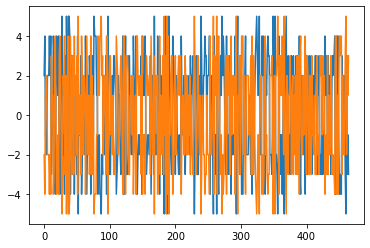

In [13]:
import matplotlib.pyplot as plt
plt.plot(scores1)
plt.plot(scores2)
plt.show()

In [14]:
# Test run
state1 = env.reset()
state1 = np.reshape(state1, [1, state_size])
state2 = state1

total_reward = 0
done = False

while not done:
    action_idx1, action1 = agent1.get_action(state1)
    action_idx2, action2 = agent1.get_action(state2)
    state1, reward, done, info = env.step(action1, action2)
    state2 = info['otherObs']
    state1 = np.reshape(state1, [1, state_size])
    state2 = np.reshape(state2, [1, state_size])
    total_reward += reward
    env.render()
print(f"Reward: {total_reward}")

Reward: -1
